# Custom Functions

In [ ]:
!pip install statsmodels==0.14.1


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


## LSTM Model

In [ ]:
# Custom class & functions: https://github.com/Eligijus112/Vilnius-weather-LSTM/blob/main/weather-analysis.ipynb

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses, optimizers
import time
import csv
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

class NNMultistepModel():
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=5,
        transfer_learning=False,
        source_model=None  # Path to full source model
    ):
        if transfer_learning and source_model:
            base_model = load_model(source_model)
            base_model_layers = base_model.layers[:-1]

            # Create a new model without the output layer
            new_model = Model(inputs=base_model.input, outputs=base_model_layers[-1].output)
            # Freeze layers of base model
            for layer in new_model.layers:
                layer.trainable = False
            
            new_output_layer = Dense(n_outputs)(new_model.layers[-1].output)
            self.model = Model(inputs=new_model.input, outputs=new_output_layer)

        else:
            lstm_input = Input(shape=(n_lag, n_ft))
            lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)
            output_layer = Dense(n_outputs)(lstm_layer)
            self.model = Model(inputs=lstm_input, outputs=output_layer)

        self.n_layer = n_layer
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience
        self.training_time = None

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self, lr, epochs, batch_size):
        # Compiling the model
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizers.Adam(learning_rate=self.lr))

        if (self.Xval is not None) and (self.Yval is not None):
            start_time = time.time()
            history = self.model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch_size, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
            end_time = time.time()
            self.training_time = end_time - start_time
            print("Training time:", self.training_time, "seconds")
        else:
            start_time = time.time()
            history = self.model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch_size,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
            end_time = time.time()
            self.training_time = end_time - start_time
            print("Training time:", self.training_time, "seconds")
        
        return history
    
    def predict(self, X):
        return self.model.predict(X)

    def set_trainable_layers(self):
        for layer in self.model.layers:
            layer.trainable = True

    def get_training_time(self):
        return self.training_time

def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

def append_model_metrics(model_name, reversed_forecast, reversed_Yval, target_index, training_time, csv_filename='model_metrics.csv'):
    """
    A method to write RMSE, MAE, R2 and time metrics to a csv file for each model 
    """
    # Reversed Metrics
    reversed_rmse = mean_squared_error(reversed_Yval, reversed_forecast, squared=False)
    reversed_mae = mean_absolute_error(reversed_Yval, reversed_forecast)
    reversed_r2 = r2_score(reversed_Yval, reversed_forecast)
    training_time = training_time

    print("Reversed RMSE:", reversed_rmse)
    print("Reversed MAE:", reversed_mae)
    print("Reversed R2 Score:", reversed_r2)
    print("Training Time:", training_time, "seconds")

    # List of metrics
    metrics_data = [
        {"Model": model_name, "RMSE": reversed_rmse, "MAE": reversed_mae, "R2": reversed_r2, "Time": training_time},
    ]

    # Define the fieldnames for the CSV file
    fieldnames = ["Model", "RMSE", "MAE", "R2", "Time"]

    # Append metrics to the CSV file
    with open(csv_filename, 'a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        
        # If the file is empty, write the header
        if file.tell() == 0:
            writer.writeheader()
        
        # Write metrics data
        for row in metrics_data:
            writer.writerow(row)

def scale_data(features, dataset, index):
    """
    A method to scale the data and split into train and test sets
    """
    dataset = dataset[features]

    test_days_df   = dataset[(dataset.index >= index)]
    test_share = len(test_days_df)/len(dataset)
    print(f'Test Share: {test_share}')

    nrows = dataset.shape[0]

    # Spliting into train and test sets
    train = dataset[0:int(nrows * (1 - test_share))]
    test = dataset[int(nrows * (1 - test_share)):]

    # Scaling the data 
    train_mean = train.mean()
    train_std = train.std()

    train = (train - train_mean) / train_std
    test = (test - train_mean) / train_std

    # Creating the final scaled frame 
    dataset_s = pd.concat([train, test])

    return dataset_s, train_mean, train_std, test_share


2024-05-06 15:37:28.456638: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 15:37:28.607215: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-06 15:37:28.607248: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-05-06 15:37:28.638763: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 15:37:29.587107: W tensorflow/stream_executor/platform/de

## Data Cleaning 

In [ ]:
import pandas as pd
import plotly.graph_objs as go
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import adfuller, kpss


class DataCleaning():
    def __init__(self, data_path, building_name, energy_type, z_threshold):
        self.data_path = data_path
        self.building_name = building_name
        self.data = None
        self.z_threshold = z_threshold
        self.energy_type = energy_type

    def clean_data(self):
        """
        Main method to perform data cleaning and data analysis
        """
        self.data = pd.read_csv(self.data_path)
        self.data
        self.set_data_index()
        self.missing_values()
        self.descriptive_stats()
        self.remove_outliers()
        self.seasonal_decomposition()
        self.cyclical_features()
        self.correlation_analysis()
        return self.data
    
    def set_data_index(self):
        """
        A method to create an index for each time series and clean the data format
        """
        if self.energy_type == "Fjv":
            self.data['Period'] = pd.to_datetime(self.data['Period'])
            self.data.set_index('Period', inplace=True)

            # Create a trace for the time series
            trace = go.Scatter(x=self.data.index, y=self.data['corrected_value'], mode='lines', name='Corrected Value')

            # Create layout for the plot
            layout = go.Layout(title=f'District Heating Consumption {self.building_name}',
                            xaxis=dict(title='Date'),
                            yaxis=dict(title='Consumption'))

            # Create Figure object
            fig = go.Figure(data=[trace], layout=layout)

            # Show the plot
            fig.show()
        
        if self.energy_type == "EL":
            # Set Datetime as index
            self.data = self.data[~self.data['Förbrukning'].str.contains('Förbrukning')]

            self.data['Period'] = pd.to_datetime(self.data['Period'])

            # Sort the DataFrame by the date column
            self.data = self.data.sort_values(by='Period')

            self.data['Förbrukning'] = pd.to_numeric(self.data['Förbrukning'])

            self.data.set_index('Period', inplace=True)

            # Rename Index name
            self.data.index.name = 'Period'

            # Create a trace for the time series
            trace = go.Scatter(x=self.data.index, y=self.data['Förbrukning'], mode='lines', name='Consumption')

            # Create layout for the plot
            layout = go.Layout(title=f'Electricity Consumption {self.building_name}',
                            xaxis=dict(title='Date'),
                            yaxis=dict(title='Consumption'))

            # Create Figure object
            fig = go.Figure(data=[trace], layout=layout)

            # Show the plot
            fig.show()

        if self.energy_type == "EL_Kinder":
            # Define the Swedish to English month mapping
            swedish_to_english_months = {
                'jan': 'Jan', 'feb': 'Feb', 'mar': 'Mar', 'apr': 'Apr', 'maj': 'May', 'jun': 'Jun',
                'jul': 'Jul', 'aug': 'Aug', 'sep': 'Sep', 'okt': 'Oct', 'nov': 'Nov', 'dec': 'Dec'
            }

            # Define a function to unify time format
            def unify_time_format(date_str):
                if date_str == 'Period':
                    return pd.NaT

                try:
                    if "T" in date_str and "Z" in date_str:
                        return pd.to_datetime(date_str, errors='coerce', utc=True).tz_convert(None)
                except Exception:
                    pass

                date_str_lower = date_str.lower()
                for swe, eng in swedish_to_english_months.items():
                    date_str_lower = date_str_lower.replace(swe, eng.capitalize())

                date_formats = ["%d %b %Y %H:%M", "%d/%m/%y %H:%M", "%d/%m/%Y %H:%M"]
                for fmt in date_formats:
                    try:
                        parsed_date = pd.to_datetime(date_str_lower, format=fmt, exact=True, errors='coerce')
                        if pd.notnull(parsed_date):
                            return parsed_date
                    except ValueError:
                        continue

                return pd.NaT

            # Apply the function to the 'Period' column
            self.data['Period'] = self.data['Period'].astype(str).apply(unify_time_format)

            # Drop rows with invalid dates or missing 'Förbrukning'
            self.data.dropna(subset=['Period', 'Förbrukning'], inplace=True)

            # Convert 'Förbrukning' to a numeric type, handling potential decimal separators
            self.data['Förbrukning'] = pd.to_numeric(self.data['Förbrukning'].str.replace(',', '.'), errors='coerce')

            # Convert 'Period' column to datetime
            self.data['Period'] = pd.to_datetime(self.data['Period'], errors='coerce')

            # Sort and reset the index
            self.data.sort_values(by='Period', inplace=True)
            self.data.reset_index(drop=True, inplace=True)

            self.data.index.name = 'Period'
            self.data.set_index('Period', inplace=True)

            # Convert the datetime index to UTC timezone
            self.data.index = self.data.index.tz_localize(None).tz_localize('UTC')

            # Create a trace for the time series
            trace = go.Scatter(x=self.data.index, y=self.data['Förbrukning'], mode='lines', name='Consumption')

            # Create layout for the plot
            layout = go.Layout(title='District Heating Consumption Tallbacka',
                            xaxis=dict(title='Date'),
                            yaxis=dict(title='Consumption'))

            # Create Figure object
            fig = go.Figure(data=[trace], layout=layout)

            # Show the plot
            fig.show()


    def missing_values(self):
        """
        A method to encounter missing values and perform linear interpolation in case of missing values
        """
        missing_values = self.data.isnull().sum()
        print(f'Missing values: {missing_values}')
        if self.energy_type == "Fjv":
            # Interpolate missing values
            self.data = self.data.infer_objects()
            self.data = self.data.interpolate(method='linear')

    def descriptive_stats(self):
        """
        A method to perform descriptive statistics for the time series
        """
        if self.energy_type == "Fjv":
            # Plot histogram with Plotly
            fig = px.histogram(self.data, x='corrected_value', nbins=30, title='Distribution of corrected_value')
            fig.update_layout(xaxis_title='Value', yaxis_title='Frequency')
            fig.show()

            # Calculate kurtosis and skewness
            kurtosis_value = stats.kurtosis(self.data['corrected_value'])
            skewness_value = stats.skew(self.data['corrected_value'])
            print("Kurtosis:", kurtosis_value)
            print("Skewness:", skewness_value)

            # Calculate descriptive statistics
            mean_value = self.data['corrected_value'].mean()
            median_value = self.data['corrected_value'].median()
            mode_value = self.data['corrected_value'].mode()[0]  
            std_dev = self.data['corrected_value'].std()

            # Print descriptive statistics
            print("Mean:", mean_value)
            print("Median:", median_value)
            print("Mode:", mode_value)
            print("Standard Deviation:", std_dev)

        if self.energy_type == "EL" or self.energy_type == "EL_Kinder":
            
            fig = px.histogram(self.data, x='Förbrukning', nbins=30, title='Distribution of Förbrukning')
            fig.update_layout(xaxis_title='Value', yaxis_title='Frequency')
            fig.show()

            # Calculate kurtosis and skewness
            kurtosis_value = stats.kurtosis(self.data['Förbrukning'])
            skewness_value = stats.skew(self.data['Förbrukning'])

            print("Kurtosis:", kurtosis_value)
            print("Skewness:", skewness_value)

            # Assuming 'df' is your DataFrame containing the data
            # Calculate descriptive statistics
            mean_value = self.data['Förbrukning'].mean()
            median_value = self.data['Förbrukning'].median()
            mode_value = self.data['Förbrukning'].mode()[0]  
            std_dev = self.data['Förbrukning'].std()

            # Print descriptive statistics
            print("Mean:", mean_value)
            print("Median:", median_value)
            print("Mode:", mode_value)
            print("Standard Deviation:", std_dev)

    def remove_outliers(self):
        """
        A method to remove outliers based on a threshold using Z-score
        """
        if self.energy_type == "Fjv":
            # Identifying rows with 0 values in 'corrected_value' feature
            zero_values = self.data[self.data['corrected_value'] == 0]

            # Remove rows with 0 values in 'corrected_value' feature
            self.data = self.data[self.data['corrected_value'] != 0]

            # Calculate Z-scores for the data
            self.data['z_score'] = (self.data['corrected_value'] - self.data['corrected_value'].mean()) / self.data['corrected_value'].std()

            # Identify outliers based on Z-score
            outliers = self.data[abs(self.data['z_score']) > self.z_threshold]

            # Print the number of outliers excluding zeros
            print("Number of outliers (excluding zeros):", outliers.shape[0])

            # Plot original data
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=self.data.index, y=self.data['corrected_value'], mode='lines'))

            # Add non-zero outliers to the plot
            fig.add_trace(go.Scatter(x=outliers.index, y=outliers['corrected_value'], mode='markers', 
                                    marker=dict(color='red', size=8), name='Outliers (Z-Score)'))

            # Add a trace for zero value data points as green dots
            if not zero_values.empty:
                fig.add_trace(go.Scatter(x=zero_values.index, y=zero_values['corrected_value'], mode='markers', 
                                        marker=dict(color='green', size=8, symbol='circle'), name='Zero Values (Outliers)'))

            # Update layout
            fig.update_layout(title='Time Series with Outliers (Z-Score and Zero Values)',
                            xaxis_title='Date',
                            yaxis_title='Corrected Value')

            # Show plot
            fig.show()

            # Remove non-zero outliers based on the Z-score
            self.data = self.data[abs(self.data['z_score']) <= self.z_threshold]

        if self.energy_type == "EL" or self.energy_type == "EL_Kinder":

            # Remove rows with 0 values in 'corrected_value' feature
            self.data = self.data[self.data['Förbrukning'] != 0]

            # Calculate Z-scores for the data
            self.data['z_score'] = (self.data['Förbrukning'] - self.data['Förbrukning'].mean()) / self.data['Förbrukning'].std()

            # Identify outliers based on Z-score
            outliers = self.data[abs(self.data['z_score']) > z_threshold]

            # Print the number of outliers excluding zeros
            print("Number of outliers (excluding zeros):", outliers.shape[0])

            # Plot original data
            fig = go.Figure()
            # Create a trace for the time series
            fig.add_trace(go.Scatter(x=self.data.index, y=self.data['Förbrukning'], mode='lines', name='Consumption'))

            # Add non-zero outliers to the plot
            fig.add_trace(go.Scatter(x=outliers.index, y=outliers['Förbrukning'], mode='markers', 
                                    marker=dict(color='red', size=8), name='Outliers (Z-Score)'))

            # Update layout
            fig.update_layout(title='Time Series with Outliers (Z-Score and Zero Values)',
                            xaxis_title='Date',
                            yaxis_title='Consumption')

            # Show plot
            fig.show()

            # Remove outliers based on the Z-score
            self.data = self.data[abs(self.data['z_score']) <= z_threshold]

    def seasonal_decomposition(self):
        """
        A method to plot a seasonal decomposition and to calculate the stationarity of the time series
        """
        if self.energy_type == "Fjv":
            index_name = "corrected_value"
        if self.energy_type == "EL" or self.energy_type == "EL_Kinder":
            index_name = "Förbrukning"
        # Decompose data by selecting the appropriate frequency
        decomp = sm.tsa.seasonal_decompose(self.data[index_name], period=365)

        # Create subplots
        fig = make_subplots(rows=4, cols=1, shared_xaxes=True,
                            subplot_titles=("Original Data", "Trend", "Seasonal", "Residual"))

        # Add original data trace
        fig.add_trace(go.Scatter(x=self.data.index, y=self.data[index_name], mode='lines', name='Original'),
                    row=1, col=1)

        # Add trend trace
        fig.add_trace(go.Scatter(x=self.data.index, y=decomp.trend, mode='lines', name='Trend'),
                    row=2, col=1)

        # Add seasonal trace
        fig.add_trace(go.Scatter(x=self.data.index, y=decomp.seasonal, mode='lines', name='Seasonal'),
                    row=3, col=1)

        # Add residual trace
        fig.add_trace(go.Scatter(x=self.data.index, y=decomp.resid, mode='lines', name='Residual'),
                    row=4, col=1)

        # Update layout
        fig.update_layout(title=f'Seasonal Decomposition {self.building_name}',
                        xaxis_title="Date",
                        showlegend=False)

        # Show plot
        fig.show()

        # Stationarity test using Augmented Dickey-Fuller test
        adf_result = adfuller(self.data[index_name].dropna())

        print('ADF Statistic: %f' % adf_result[0])
        print('p-value: %f' % adf_result[1])
        print('Critical Values:')
        for key, value in adf_result[4].items():
            print('\t%s: %.3f' % (key, value))


    def cyclical_features(self):
        """
        A method to create cyclical features for sin and cos of year, month and week day.
        """
        # Extract day of week, day of month, month, and day of year from the date
        self.data['dayofweek'] = self.data.index.dayofweek
        self.data['day'] =self.data.index.day
        self.data['month'] = self.data.index.month
        self.data['dayofyear'] = self.data.index.dayofyear

        # Create cyclical features for day of week
        self.data['dayofweek_sin'] = np.sin(2 * np.pi * self.data['dayofweek'] / 7)
        self.data['dayofweek_cos'] = np.cos(2 * np.pi * self.data['dayofweek'] / 7)

        # Create cyclical features for day of month
        self.data['day_sin'] = np.sin(2 * np.pi * self.data['day'] / 31)
        self.data['day_cos'] = np.cos(2 * np.pi * self.data['day'] / 31)

        # Create cyclical features for month
        self.data['month_sin'] = np.sin(2 * np.pi * self.data['month'] / 12)
        self.data['month_cos'] = np.cos(2 * np.pi * self.data['month'] / 12)

        # Create cyclical features for day of year
        self.data['dayofyear_sin'] = np.sin(2 * np.pi * self.data['dayofyear'] / 365)
        self.data['dayofyear_cos'] = np.cos(2 * np.pi * self.data['dayofyear'] / 365)
        
    def correlation_analysis(self):
        """
        A method to perform corerlation analysis with Pearson method
        """
        if self.energy_type == "Fjv":
            index_name = "corrected_value"
            features   = ['corrected_value', 'Akt', 'dayofweek_sin', 'dayofweek_cos','month_sin','month_cos','dayofyear_sin','dayofyear_cos','day_sin','day_cos']
        if self.energy_type == "EL" or self.energy_type == "EL_Kinder":
            index_name = "Förbrukning"
            features   = ['Förbrukning', 'dayofweek_sin', 'dayofweek_cos','month_sin','month_cos','dayofyear_sin','dayofyear_cos','day_sin','day_cos']

        # Calculate correlation coefficients
        corr_matrix = self.data[features].corr()
        display(corr_matrix[index_name])

        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(11, 9))

        # Generate a custom diverging colormap
        cmap = sns.color_palette("viridis", as_cmap=True) 

        # Draw the heatmap with the mask and correct aspect ratio
        sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")  # Adjusting vmin and vmax

        plt.show()

## Standard model (No Transfer Learning)

In [ ]:
def no_tl(features, data_clean, index, lag, n_ahead, n_layer, learning_rate, epochs, batch_size):
    """
    A method to create a Multivariate LSTM standard model with no TL
    """
    data_clean_s, train_mean, train_std, test_share = scale_data(features, data_clean, index)
    X, Y = create_X_Y(data_clean_s.values, lag=lag, n_ahead=n_ahead)
    n_ft = X.shape[2]

    # Spliting into train and test sets 
    Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
    Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

    print(f"Shape of training data: {Xtrain.shape}")
    print(f"Shape of the target data: {Ytrain.shape}")

    print(f"Shape of validation data: {Xval.shape}")
    print(f"Shape of the validation target data: {Yval.shape}")

    model = NNMultistepModel(
        X=Xtrain,
        Y=Ytrain,
        n_outputs=n_ahead,
        n_lag=lag,
        n_ft=n_ft,
        n_layer=n_layer,
        Xval=Xval,
        Yval=Yval,
    )
    model.model.summary()

    history = model.train(lr=learning_rate,epochs=epochs, batch_size=batch_size)
    training_time = model.get_training_time()
    
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    n_epochs = range(len(loss))
    plt.figure(figsize=(9, 7))
    plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
    if val_loss is not None:
        plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
    plt.legend(loc=0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss value')
    plt.show()

    # Forecasting on all the samples in the validation set 
    forecast = model.predict(Xval)
    target_index = 0

    # Reversed Metrics
    reversed_forecast = forecast * train_std[target_index] + train_mean[target_index]
    reversed_Yval = Yval * train_std[target_index] + train_mean[target_index]

    model_name = f'{building_name}_std'

    append_model_metrics(model_name, reversed_forecast, reversed_Yval, target_index, training_time)


## Transfer Learning 

In [ ]:
def tl(features, data_clean, index, lag, n_ahead, n_layer, learning_rate, epochs, batch_size, source_model_path, data_sample):
    """
    A method to create a Multivariate LSTM model with TL using different portions of the data
    """
    for k,v in data_sample.items():
        separator = "=" * 130 
        print()
        print()
        print(separator)
        print(f'Transfer Learning using {k}% of the data')
        print(separator)
        print()

        # Calculate the index to start slicing from
        start_index = int(v * len(data_clean))

        # Select the last sample % of records
        data_sample = data_clean.iloc[start_index:]

        data_clean_s, train_mean_sample, train_std_sample, test_share_sample = scale_data(features, data_sample, index)
        display(data_clean_s)
        X, Y = create_X_Y(data_clean_s.values, lag=lag, n_ahead=n_ahead)
        n_ft = X.shape[2]

        # Spliting into train and test sets 
        Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share_sample))], Y[0:int(X.shape[0] * (1 - test_share_sample))]
        Xval, Yval = X[int(X.shape[0] * (1 - test_share_sample)):], Y[int(X.shape[0] * (1 - test_share_sample)):]

        print(f"Shape of training data: {Xtrain.shape}")
        print(f"Shape of the target data: {Ytrain.shape}")

        print(f"Shape of validation data: {Xval.shape}")
        print(f"Shape of the validation target data: {Yval.shape}")

        model = NNMultistepModel(
            X=Xtrain,
            Y=Ytrain,
            n_outputs=n_ahead,
            n_lag=lag,
            n_ft=n_ft,
            n_layer=n_layer,
            Xval=Xval,
            Yval=Yval,
            transfer_learning=True,
            source_model=source_model_path
        )

        model.model.summary()

        history = model.train(lr=0.01,epochs=20, batch_size=batch_size)
        training_time = model.get_training_time()

        loss = history.history.get('loss')
        val_loss = history.history.get('val_loss')
        n_epochs = range(len(loss))

        plt.figure(figsize=(9, 7))
        plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
        if val_loss is not None:
            plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
        plt.legend(loc=0)
        plt.xlabel('Epoch')
        plt.ylabel('Loss value')
        plt.show()

        model.set_trainable_layers()
        history = model.train(lr=0.0001, epochs=epochs, batch_size=batch_size)

        training_time_ft = model.get_training_time()

        # Forecasting on all the samples in the validation set 
        forecast = model.predict(Xval)

        target_index = 0

        # Reversed Metrics
        reversed_forecast = forecast * train_std_sample[target_index] + train_mean_sample[target_index]
        reversed_Yval = Yval * train_std_sample[target_index] + train_mean_sample[target_index]

        model_name = f'{building_name}_{k}'
        total_training_time = training_time + training_time_ft

        append_model_metrics(model_name, reversed_forecast, reversed_Yval, target_index, total_training_time)


# Experiments

## Parameters definition

In [ ]:
# Number of lags (days back) to use for models
lag = 7 

# Steps ahead to forecast
n_ahead = 3 

# Number of neurons in LSTM layer
n_layer = 20   

# Learning rate from Source Model
learning_rate = 0.01 

# Number of epochs from Source Model
epochs = 100  

# Batch size from Source Model
batch_size = 32

# Threshold for Z-score outlier removal
z_threshold = 2.25

# Features to use for the model (selected after correlation analysis)
features = ['Förbrukning', 'dayofweek_sin', 'dayofweek_cos']

# Path to the dataset
path = "/work/Fastighets_Energy_Data.Tallbacka_EL.csv"

# Type of energy (Fjv, EL, EL_Kinder)
energy_type = "EL_Kinder"

# Index to define test set
index = '2023-06-01'

# Building name
building_name = "Tallbacka"

# Path to the source model weights 
source_model_path = "/work/norrbacka_el_model.h5"

# Data portion for each TL model
data_sample = {"10": 0.9, "20": 0.8, "30": 0.7, "40": 0.6, "50": 0.5, "60": 0.4, "70": 0.3, "80": 0.2, "90": 0.1, "100": 0.0}

## Data cleaning

Missing values: _id            0
Förbrukning    0
dtype: int64


Kurtosis: -1.3513903190227774
Skewness: -0.2729499011985992
Mean: 677.9944770681527
Median: 745.301
Mode: 259.464
Standard Deviation: 254.93817818777467
Number of outliers (excluding zeros): 1


ADF Statistic: -4.820122
p-value: 0.000050
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Förbrukning      1.000000
dayofweek_sin    0.656003
dayofweek_cos   -0.130101
month_sin        0.070715
month_cos        0.365818
dayofyear_sin   -0.030149
dayofyear_cos    0.372950
day_sin         -0.021294
day_cos         -0.038669
Name: Förbrukning, dtype: float64

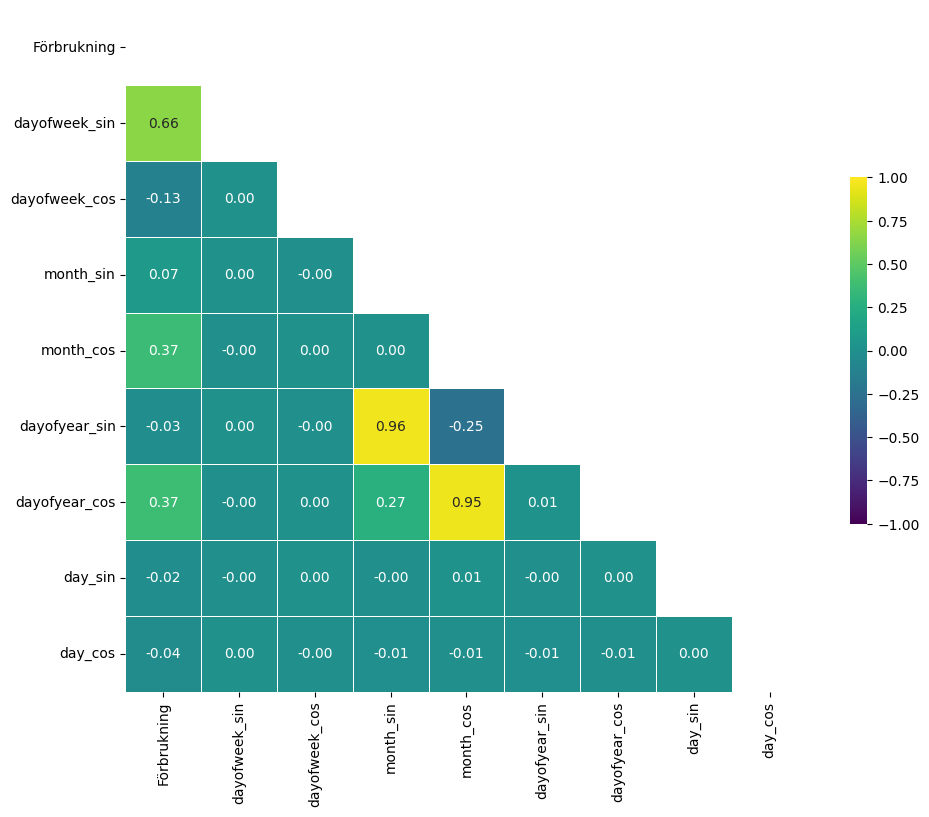

In [ ]:
Tallbacka_EL      = DataCleaning(path, building_name, energy_type, z_threshold)
Tallbacka_EL_clean = Tallbacka_EL.clean_data()

## NO_TL Model

Test Share: 0.07204116638078903
Shape of training data: (2154, 7, 3)
Shape of the target data: (2154, 3)
Shape of validation data: (168, 7, 3)
Shape of the validation target data: (168, 3)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 3)]            0         
                                                                 
 lstm (LSTM)                 (None, 20)                1920      
                                                                 
 dense (Dense)               (None, 3)                 63        
                                                                 
Total params: 1,983
Trainable params: 1,983
Non-trainable params: 0
_________________________________________________________________
2024-05-06 15:37:34.646361: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so

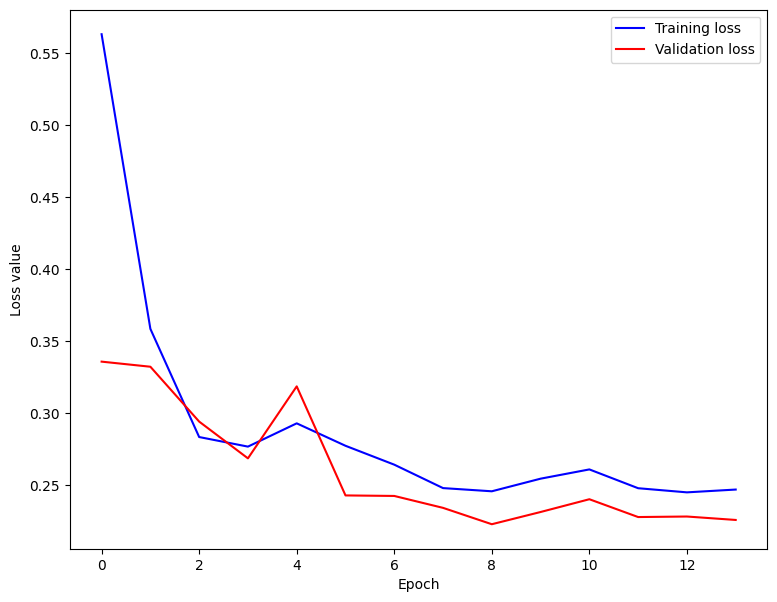

6/6 [==============================] - 0s 2ms/step
Reversed RMSE: 77.1878408648444
Reversed MAE: 57.368027895488446
Reversed R2 Score: 0.9079465002232491
Training Time: 7.536067485809326 seconds
/tmp/ipykernel_6271/221258124.py:51: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipykernel_6271/221258124.py:52: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [ ]:
no_tl(
    features, 
    Tallbacka_EL_clean, 
    index, 
    lag, 
    n_ahead, 
    n_layer, 
    learning_rate, 
    epochs, 
    batch_size
)

## TL Model



Transfer Learning using 10% of the data

Test Share: 0.717948717948718


,Förbrukning,dayofweek_sin,dayofweek_cos
Period,,,
2023-03-27 00:00:00+00:00,1.069387,-0.037348,1.375576
2023-03-28 00:00:00+00:00,1.261785,1.059671,0.846425
2023-03-29 00:00:00+00:00,1.051303,1.330613,-0.342565
2023-03-30 00:00:00+00:00,0.928379,0.571452,-1.296061
2023-03-31 00:00:00+00:00,0.839213,-0.646148,-1.296061
...,...,...,...
2023-11-11 00:00:00+00:00,-1.044782,-1.405309,-0.342565
2023-11-12 00:00:00+00:00,-1.025893,-1.134368,0.846425
2023-11-13 00:00:00+00:00,1.440670,-0.037348,1.375576


Shape of training data: (63, 7, 3)
Shape of the target data: (63, 3)
Shape of validation data: (161, 7, 3)
Shape of the validation target data: (161, 3)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 7, 3)]            0         
                                                                 
 lstm_10 (LSTM)              (None, 20)                1920      
                                                                 
 dense_1 (Dense)             (None, 3)                 63        
                                                                 
Total params: 1,983
Trainable params: 63
Non-trainable params: 1,920
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 1s 293ms/step - loss: 0.9084 - val_loss: 0.9811
Epoch 2/20
2/2 [==============================] - 0s 30ms/step - loss

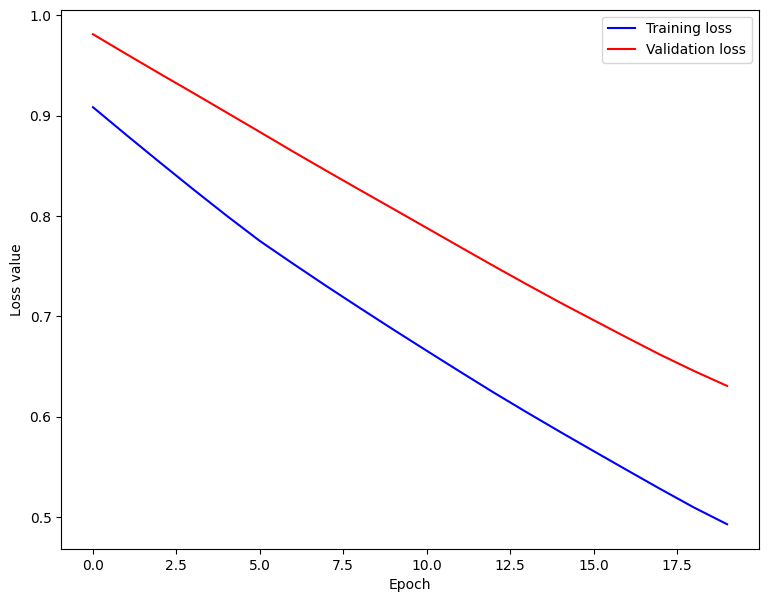

Epoch 1/100
2/2 [==============================] - 1s 270ms/step - loss: 0.4808 - val_loss: 0.6302
Epoch 2/100
2/2 [==============================] - 0s 53ms/step - loss: 0.4802 - val_loss: 0.6297
Epoch 3/100
2/2 [==============================] - 0s 51ms/step - loss: 0.4796 - val_loss: 0.6292
Epoch 4/100
2/2 [==============================] - 0s 39ms/step - loss: 0.4791 - val_loss: 0.6287
Epoch 5/100
2/2 [==============================] - 0s 27ms/step - loss: 0.4785 - val_loss: 0.6282
Epoch 6/100
2/2 [==============================] - 0s 96ms/step - loss: 0.4779 - val_loss: 0.6277
Epoch 7/100
2/2 [==============================] - 0s 26ms/step - loss: 0.4773 - val_loss: 0.6271
Epoch 8/100
2/2 [==============================] - 0s 47ms/step - loss: 0.4767 - val_loss: 0.6266
Epoch 9/100
2/2 [==============================] - 0s 49ms/step - loss: 0.4761 - val_loss: 0.6261
Epoch 10/100
2/2 [==============================] - 0s 58ms/step - loss: 0.4755 - val_loss: 0.6256
Epoch 11/100
2/2 [

,Förbrukning,dayofweek_sin,dayofweek_cos
Period,,,
2022-08-06 00:00:00+00:00,-1.562881,-1.373587e+00,-0.323361
2022-08-07 00:00:00+00:00,-1.883483,-1.101532e+00,0.873619
2022-08-08 00:00:00+00:00,-0.431850,-2.144898e-17,1.406325
2022-08-09 00:00:00+00:00,-0.734042,1.101532e+00,0.873619
2022-08-10 00:00:00+00:00,-0.394302,1.373587e+00,-0.323361
...,...,...,...
2023-11-11 00:00:00+00:00,-1.380935,-1.373587e+00,-0.323361
2023-11-12 00:00:00+00:00,-1.362175,-1.101532e+00,0.873619
2023-11-13 00:00:00+00:00,1.087607,-2.144898e-17,1.406325


Shape of training data: (292, 7, 3)
Shape of the target data: (292, 3)
Shape of validation data: (165, 7, 3)
Shape of the validation target data: (165, 3)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 7, 3)]            0         
                                                                 
 lstm_10 (LSTM)              (None, 20)                1920      
                                                                 
 dense_2 (Dense)             (None, 3)                 63        
                                                                 
Total params: 1,983
Trainable params: 63
Non-trainable params: 1,920
_________________________________________________________________
Epoch 1/20
10/10 [==============================] - 1s 30ms/step - loss: 0.8839 - val_loss: 0.9613
Epoch 2/20
10/10 [==============================] - 0s 5ms/step - 

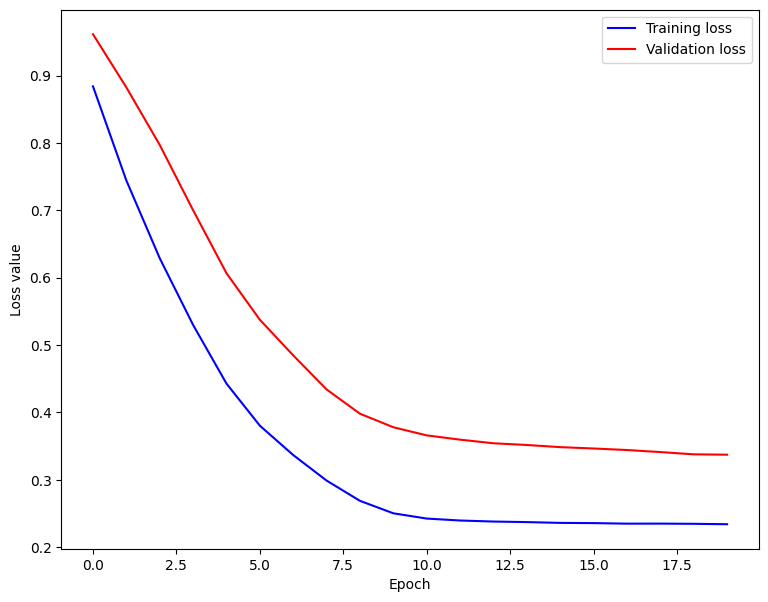

Epoch 1/100
10/10 [==============================] - 1s 35ms/step - loss: 0.2336 - val_loss: 0.3374
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 0.2332 - val_loss: 0.3371
Epoch 3/100
10/10 [==============================] - 0s 9ms/step - loss: 0.2331 - val_loss: 0.3369
Epoch 4/100
10/10 [==============================] - 0s 8ms/step - loss: 0.2330 - val_loss: 0.3368
Epoch 5/100
10/10 [==============================] - 0s 9ms/step - loss: 0.2328 - val_loss: 0.3367
Epoch 6/100
10/10 [==============================] - 0s 9ms/step - loss: 0.2327 - val_loss: 0.3366
Training time: 1.9500410556793213 seconds
6/6 [==============================] - 0s 2ms/step
Reversed RMSE: 104.40071163398426
Reversed MAE: 80.96872599530467
Reversed R2 Score: 0.8268616700667576
Training Time: 4.768844127655029 seconds
/tmp/ipykernel_6271/697795607.py:77: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be trea

,Förbrukning,dayofweek_sin,dayofweek_cos
Period,,,
2021-12-15 00:00:00+00:00,1.165387,1.372300,-0.314396
2021-12-16 00:00:00+00:00,1.014013,0.607857,-1.272964
2021-12-17 00:00:00+00:00,0.854898,-0.618214,-1.272964
2021-12-18 00:00:00+00:00,-1.129780,-1.382657,-0.314396
2021-12-19 00:00:00+00:00,-1.267001,-1.109830,0.880919
...,...,...,...
2023-11-11 00:00:00+00:00,-1.195505,-1.382657,-0.314396
2023-11-12 00:00:00+00:00,-1.176800,-1.109830,0.880919
2023-11-13 00:00:00+00:00,1.265874,-0.005178,1.412884


Shape of training data: (524, 7, 3)
Shape of the target data: (524, 3)
Shape of validation data: (166, 7, 3)
Shape of the validation target data: (166, 3)
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 7, 3)]            0         
                                                                 
 lstm_10 (LSTM)              (None, 20)                1920      
                                                                 
 dense_3 (Dense)             (None, 3)                 63        
                                                                 
Total params: 1,983
Trainable params: 63
Non-trainable params: 1,920
_________________________________________________________________
Epoch 1/20
17/17 [==============================] - 2s 21ms/step - loss: 0.7325 - val_loss: 0.6748
Epoch 2/20
17/17 [==============================] - 0s 7ms/step - 

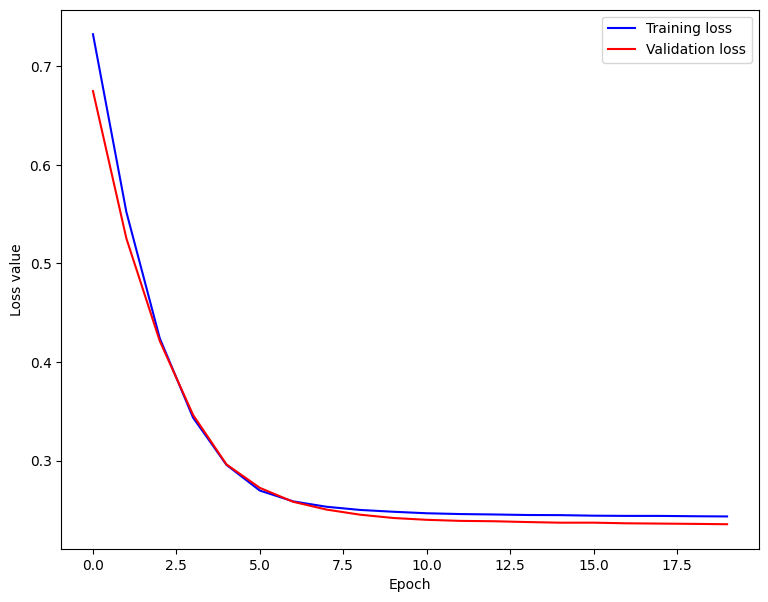

Epoch 1/100
17/17 [==============================] - 1s 21ms/step - loss: 0.2420 - val_loss: 0.2357
Epoch 2/100
17/17 [==============================] - 0s 6ms/step - loss: 0.2416 - val_loss: 0.2359
Epoch 3/100
17/17 [==============================] - 0s 7ms/step - loss: 0.2414 - val_loss: 0.2360
Epoch 4/100
17/17 [==============================] - 0s 7ms/step - loss: 0.2413 - val_loss: 0.2360
Epoch 5/100
17/17 [==============================] - 0s 5ms/step - loss: 0.2411 - val_loss: 0.2360
Epoch 6/100
17/17 [==============================] - 0s 9ms/step - loss: 0.2410 - val_loss: 0.2361
Epoch 7/100
17/17 [==============================] - 0s 9ms/step - loss: 0.2408 - val_loss: 0.2361
Epoch 8/100
17/17 [==============================] - 0s 8ms/step - loss: 0.2407 - val_loss: 0.2361
Epoch 9/100
17/17 [==============================] - 0s 5ms/step - loss: 0.2406 - val_loss: 0.2361
Epoch 10/100
17/17 [==============================] - 0s 6ms/step - loss: 0.2404 - val_loss: 0.2361
Epoch 11

,Förbrukning,dayofweek_sin,dayofweek_cos
Period,,,
2021-04-26 00:00:00+00:00,0.737172,-0.005049,1.409580
2021-04-27 00:00:00+00:00,0.959336,1.100481,0.877730
2021-04-28 00:00:00+00:00,1.074455,1.373524,-0.317326
2021-04-29 00:00:00+00:00,0.821065,0.608474,-1.275686
2021-04-30 00:00:00+00:00,0.530235,-0.618572,-1.275686
...,...,...,...
2023-11-11 00:00:00+00:00,-1.144915,-1.383622,-0.317326
2023-11-12 00:00:00+00:00,-1.126137,-1.110579,0.877730
2023-11-13 00:00:00+00:00,1.326034,-0.005049,1.409580


Shape of training data: (756, 7, 3)
Shape of the target data: (756, 3)
Shape of validation data: (167, 7, 3)
Shape of the validation target data: (167, 3)
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 7, 3)]            0         
                                                                 
 lstm_10 (LSTM)              (None, 20)                1920      
                                                                 
 dense_4 (Dense)             (None, 3)                 63        
                                                                 
Total params: 1,983
Trainable params: 63
Non-trainable params: 1,920
_________________________________________________________________
Epoch 1/20
24/24 [==============================] - 1s 18ms/step - loss: 0.7000 - val_loss: 0.6370
Epoch 2/20
24/24 [==============================] - 0s 6ms/step - 

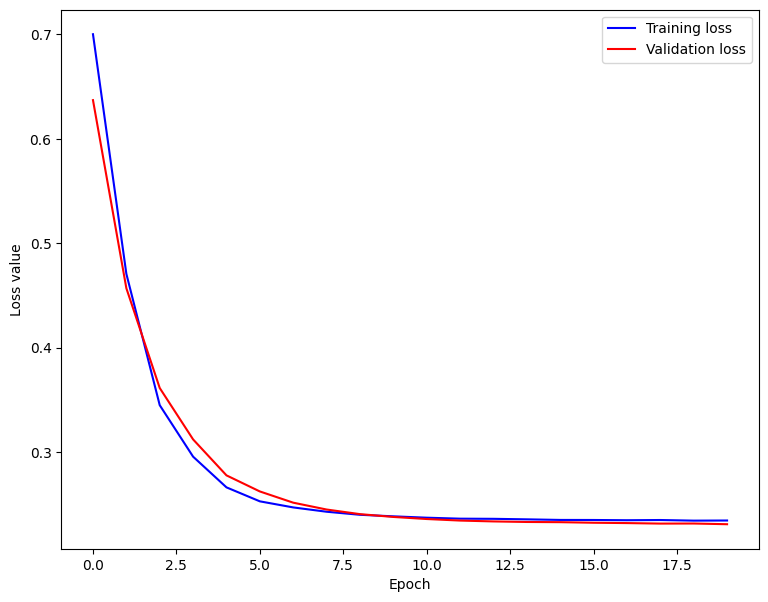

Epoch 1/100
24/24 [==============================] - 2s 16ms/step - loss: 0.2325 - val_loss: 0.2312
Epoch 2/100
24/24 [==============================] - 0s 8ms/step - loss: 0.2319 - val_loss: 0.2313
Epoch 3/100
24/24 [==============================] - 0s 5ms/step - loss: 0.2316 - val_loss: 0.2313
Epoch 4/100
24/24 [==============================] - 0s 7ms/step - loss: 0.2314 - val_loss: 0.2314
Epoch 5/100
24/24 [==============================] - 0s 8ms/step - loss: 0.2312 - val_loss: 0.2313
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 0.2310 - val_loss: 0.2313
Epoch 7/100
24/24 [==============================] - 0s 7ms/step - loss: 0.2309 - val_loss: 0.2312
Epoch 8/100
24/24 [==============================] - 0s 9ms/step - loss: 0.2308 - val_loss: 0.2312
Epoch 9/100
24/24 [==============================] - 0s 8ms/step - loss: 0.2306 - val_loss: 0.2311
Training time: 2.9773130416870117 seconds
6/6 [==============================] - 0s 2ms/step
Reversed RMSE: 

,Förbrukning,dayofweek_sin,dayofweek_cos
Period,,,
2020-09-05 00:00:00+00:00,-1.452436,-1.378448e+00,-0.317633
2020-09-06 00:00:00+00:00,-1.635084,-1.105430e+00,0.877880
2020-09-07 00:00:00+00:00,0.274956,-1.354040e-17,1.409933
2020-09-08 00:00:00+00:00,0.526009,1.105430e+00,0.877880
2020-09-09 00:00:00+00:00,0.647831,1.378448e+00,-0.317633
...,...,...,...
2023-11-11 00:00:00+00:00,-1.178286,-1.378448e+00,-0.317633
2023-11-12 00:00:00+00:00,-1.159579,-1.105430e+00,0.877880
2023-11-13 00:00:00+00:00,1.283298,-1.354040e-17,1.409933


Shape of training data: (989, 7, 3)
Shape of the target data: (989, 3)
Shape of validation data: (167, 7, 3)
Shape of the validation target data: (167, 3)
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 7, 3)]            0         
                                                                 
 lstm_10 (LSTM)              (None, 20)                1920      
                                                                 
 dense_5 (Dense)             (None, 3)                 63        
                                                                 
Total params: 1,983
Trainable params: 63
Non-trainable params: 1,920
_________________________________________________________________
Epoch 1/20
31/31 [==============================] - 1s 14ms/step - loss: 0.7508 - val_loss: 0.6512
Epoch 2/20
31/31 [==============================] - 0s 3ms/step -

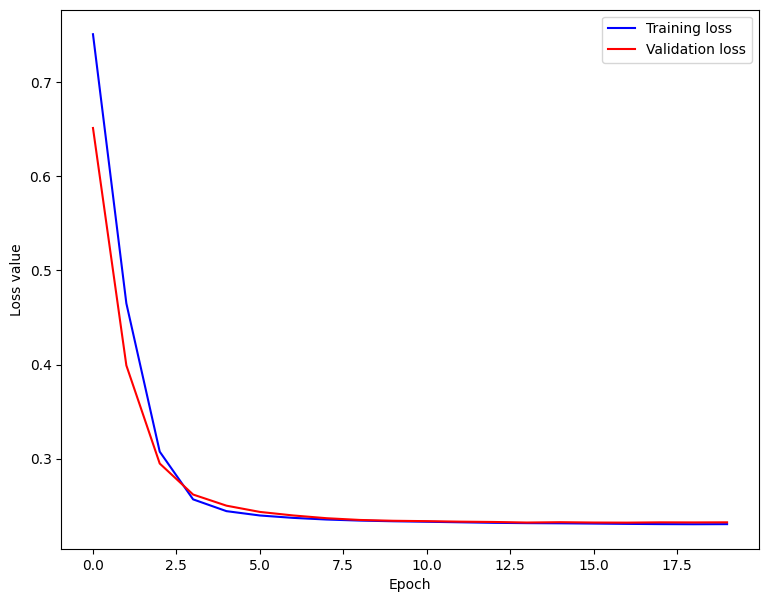

Epoch 1/100
31/31 [==============================] - 1s 14ms/step - loss: 0.2286 - val_loss: 0.2324
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.2277 - val_loss: 0.2325
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.2274 - val_loss: 0.2325
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 0.2271 - val_loss: 0.2324
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.2269 - val_loss: 0.2324
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 0.2268 - val_loss: 0.2323
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 0.2266 - val_loss: 0.2322
Epoch 8/100
31/31 [==============================] - 0s 7ms/step - loss: 0.2264 - val_loss: 0.2321
Training time: 3.1263480186462402 seconds
6/6 [==============================] - 0s 1ms/step
Reversed RMSE: 75.54209124753179
Reversed MAE: 55.98348225326692
Reversed R2 Score: 0.912298733827483
Training Ti

,Förbrukning,dayofweek_sin,dayofweek_cos
Period,,,
2020-01-15 00:00:00+00:00,1.148159,1.375963,-0.314564
2020-01-16 00:00:00+00:00,1.437504,0.611119,-1.273645
2020-01-17 00:00:00+00:00,0.974705,-0.615594,-1.273645
2020-01-18 00:00:00+00:00,-1.011613,-1.380437,-0.314564
2020-01-19 00:00:00+00:00,-1.210819,-1.107468,0.881390
...,...,...,...
2023-11-11 00:00:00+00:00,-1.112718,-1.380437,-0.314564
2023-11-12 00:00:00+00:00,-1.094154,-1.107468,0.881390
2023-11-13 00:00:00+00:00,1.330138,-0.002237,1.413639


Shape of training data: (1223, 7, 3)
Shape of the target data: (1223, 3)
Shape of validation data: (167, 7, 3)
Shape of the validation target data: (167, 3)
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 7, 3)]            0         
                                                                 
 lstm_10 (LSTM)              (None, 20)                1920      
                                                                 
 dense_6 (Dense)             (None, 3)                 63        
                                                                 
Total params: 1,983
Trainable params: 63
Non-trainable params: 1,920
_________________________________________________________________
Epoch 1/20
39/39 [==============================] - 1s 10ms/step - loss: 0.6973 - val_loss: 0.5526
Epoch 2/20
39/39 [==============================] - 0s 5ms/step

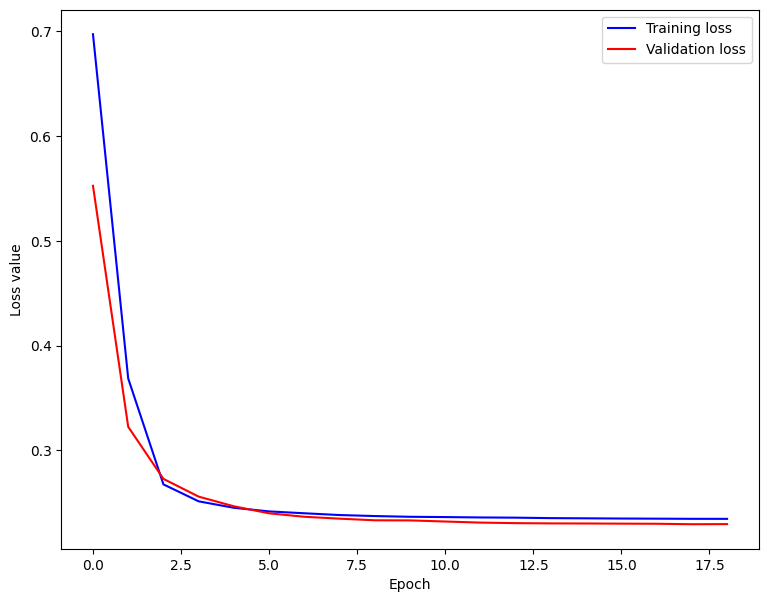

Epoch 1/100
39/39 [==============================] - 2s 12ms/step - loss: 0.2338 - val_loss: 0.2290
Epoch 2/100
39/39 [==============================] - 0s 5ms/step - loss: 0.2324 - val_loss: 0.2289
Epoch 3/100
39/39 [==============================] - 0s 7ms/step - loss: 0.2317 - val_loss: 0.2290
Epoch 4/100
39/39 [==============================] - 0s 6ms/step - loss: 0.2313 - val_loss: 0.2291
Epoch 5/100
39/39 [==============================] - 0s 6ms/step - loss: 0.2311 - val_loss: 0.2291
Epoch 6/100
39/39 [==============================] - 0s 7ms/step - loss: 0.2309 - val_loss: 0.2290
Epoch 7/100
39/39 [==============================] - 0s 7ms/step - loss: 0.2307 - val_loss: 0.2288
Epoch 8/100
39/39 [==============================] - 0s 7ms/step - loss: 0.2306 - val_loss: 0.2288
Epoch 9/100
39/39 [==============================] - 0s 7ms/step - loss: 0.2304 - val_loss: 0.2287
Training time: 4.2945544719696045 seconds
6/6 [==============================] - 0s 4ms/step
Reversed RMSE: 

,Förbrukning,dayofweek_sin,dayofweek_cos
Period,,,
2019-05-27 00:00:00+00:00,0.676501,-0.002637,1.411791
2019-05-28 00:00:00+00:00,0.454842,1.102960,0.879648
2019-05-29 00:00:00+00:00,0.360969,1.376020,-0.316068
2019-05-30 00:00:00+00:00,-1.197469,0.610923,-1.274957
2019-05-31 00:00:00+00:00,0.073119,-0.616197,-1.274957
...,...,...,...
2023-11-11 00:00:00+00:00,-1.045984,-1.381293,-0.316068
2023-11-12 00:00:00+00:00,-1.027706,-1.108233,0.879648
2023-11-13 00:00:00+00:00,1.359276,-0.002637,1.411791


Shape of training data: (1456, 7, 3)
Shape of the target data: (1456, 3)
Shape of validation data: (167, 7, 3)
Shape of the validation target data: (167, 3)
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 7, 3)]            0         
                                                                 
 lstm_10 (LSTM)              (None, 20)                1920      
                                                                 
 dense_7 (Dense)             (None, 3)                 63        
                                                                 
Total params: 1,983
Trainable params: 63
Non-trainable params: 1,920
_________________________________________________________________
Epoch 1/20
46/46 [==============================] - 1s 9ms/step - loss: 0.7173 - val_loss: 0.5278
Epoch 2/20
46/46 [==============================] - 0s 4ms/step 

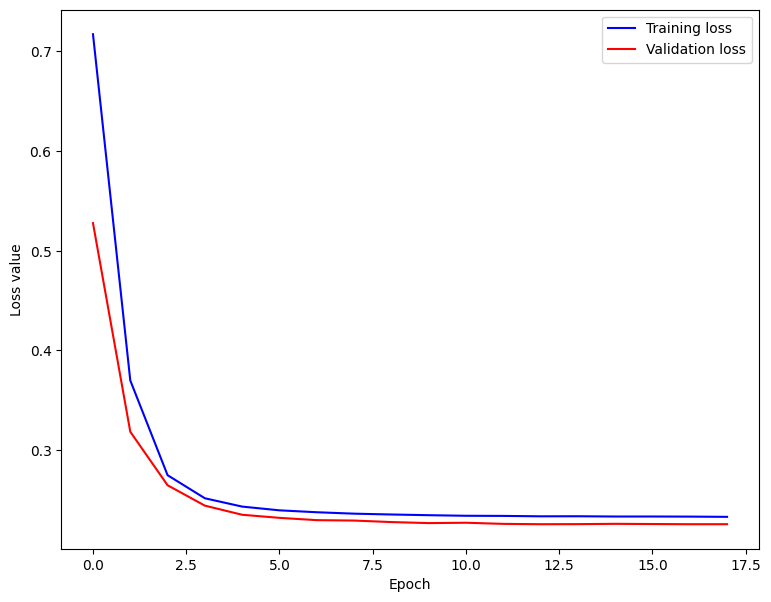

Epoch 1/100
46/46 [==============================] - 2s 11ms/step - loss: 0.2326 - val_loss: 0.2242
Epoch 2/100
46/46 [==============================] - 0s 6ms/step - loss: 0.2306 - val_loss: 0.2239
Epoch 3/100
46/46 [==============================] - 0s 6ms/step - loss: 0.2299 - val_loss: 0.2238
Epoch 4/100
46/46 [==============================] - 0s 8ms/step - loss: 0.2294 - val_loss: 0.2237
Epoch 5/100
46/46 [==============================] - 0s 5ms/step - loss: 0.2291 - val_loss: 0.2236
Epoch 6/100
46/46 [==============================] - 0s 6ms/step - loss: 0.2289 - val_loss: 0.2235
Epoch 7/100
46/46 [==============================] - 0s 5ms/step - loss: 0.2286 - val_loss: 0.2233
Epoch 8/100
46/46 [==============================] - 0s 7ms/step - loss: 0.2284 - val_loss: 0.2232
Epoch 9/100
46/46 [==============================] - 0s 6ms/step - loss: 0.2283 - val_loss: 0.2231
Epoch 10/100
46/46 [==============================] - 0s 7ms/step - loss: 0.2281 - val_loss: 0.2229
Epoch 11

,Förbrukning,dayofweek_sin,dayofweek_cos
Period,,,
2018-10-06 00:00:00+00:00,-1.476758,-1.379022,-0.316318
2018-10-07 00:00:00+00:00,-1.455153,-1.106050,0.879893
2018-10-08 00:00:00+00:00,0.828707,-0.000812,1.412257
2018-10-09 00:00:00+00:00,0.748136,1.104427,0.879893
2018-10-10 00:00:00+00:00,0.531266,1.377399,-0.316318
...,...,...,...
2023-11-11 00:00:00+00:00,-1.053323,-1.379022,-0.316318
2023-11-12 00:00:00+00:00,-1.035331,-1.106050,0.879893
2023-11-13 00:00:00+00:00,1.314164,-0.000812,1.412257


Shape of training data: (1688, 7, 3)
Shape of the target data: (1688, 3)
Shape of validation data: (168, 7, 3)
Shape of the validation target data: (168, 3)
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 7, 3)]            0         
                                                                 
 lstm_10 (LSTM)              (None, 20)                1920      
                                                                 
 dense_8 (Dense)             (None, 3)                 63        
                                                                 
Total params: 1,983
Trainable params: 63
Non-trainable params: 1,920
_________________________________________________________________
Epoch 1/20
53/53 [==============================] - 1s 8ms/step - loss: 0.6767 - val_loss: 0.4676
Epoch 2/20
53/53 [==============================] - 0s 4ms/step 

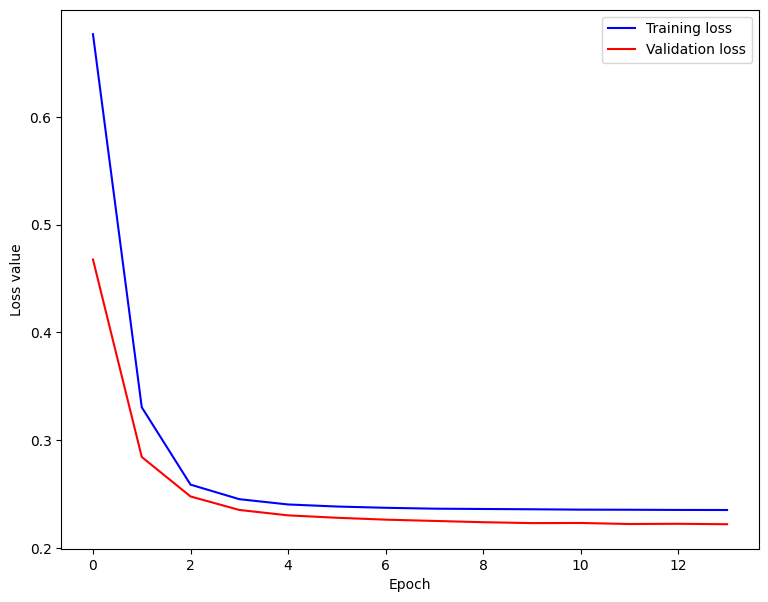

Epoch 1/100
53/53 [==============================] - 2s 10ms/step - loss: 0.2342 - val_loss: 0.2206
Epoch 2/100
53/53 [==============================] - 0s 7ms/step - loss: 0.2324 - val_loss: 0.2203
Epoch 3/100
53/53 [==============================] - 0s 7ms/step - loss: 0.2316 - val_loss: 0.2200
Epoch 4/100
53/53 [==============================] - 0s 6ms/step - loss: 0.2311 - val_loss: 0.2198
Epoch 5/100
53/53 [==============================] - 0s 6ms/step - loss: 0.2308 - val_loss: 0.2197
Epoch 6/100
53/53 [==============================] - 0s 6ms/step - loss: 0.2305 - val_loss: 0.2195
Epoch 7/100
53/53 [==============================] - 0s 6ms/step - loss: 0.2303 - val_loss: 0.2194
Epoch 8/100
53/53 [==============================] - 0s 6ms/step - loss: 0.2301 - val_loss: 0.2193
Epoch 9/100
53/53 [==============================] - 0s 6ms/step - loss: 0.2299 - val_loss: 0.2191
Epoch 10/100
53/53 [==============================] - 0s 7ms/step - loss: 0.2297 - val_loss: 0.2190
Epoch 11

,Förbrukning,dayofweek_sin,dayofweek_cos
Period,,,
2018-02-15 00:00:00+00:00,1.381054,6.137319e-01,-1.273564
2018-02-16 00:00:00+00:00,0.938861,-6.137319e-01,-1.273564
2018-02-17 00:00:00+00:00,-1.077750,-1.379043e+00,-0.314790
2018-02-18 00:00:00+00:00,-1.236471,-1.105907e+00,0.880782
2018-02-19 00:00:00+00:00,0.990392,-1.399544e-17,1.412862
...,...,...,...
2023-11-11 00:00:00+00:00,-1.038756,-1.379043e+00,-0.314790
2023-11-12 00:00:00+00:00,-1.020690,-1.105907e+00,0.880782
2023-11-13 00:00:00+00:00,1.338487,-1.399544e-17,1.412862


Shape of training data: (1921, 7, 3)
Shape of the target data: (1921, 3)
Shape of validation data: (168, 7, 3)
Shape of the validation target data: (168, 3)
Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 7, 3)]            0         
                                                                 
 lstm_10 (LSTM)              (None, 20)                1920      
                                                                 
 dense_9 (Dense)             (None, 3)                 63        
                                                                 
Total params: 1,983
Trainable params: 63
Non-trainable params: 1,920
_________________________________________________________________
Epoch 1/20
61/61 [==============================] - 2s 15ms/step - loss: 0.5958 - val_loss: 0.3956
Epoch 2/20
61/61 [==============================] - 0s 4ms/step

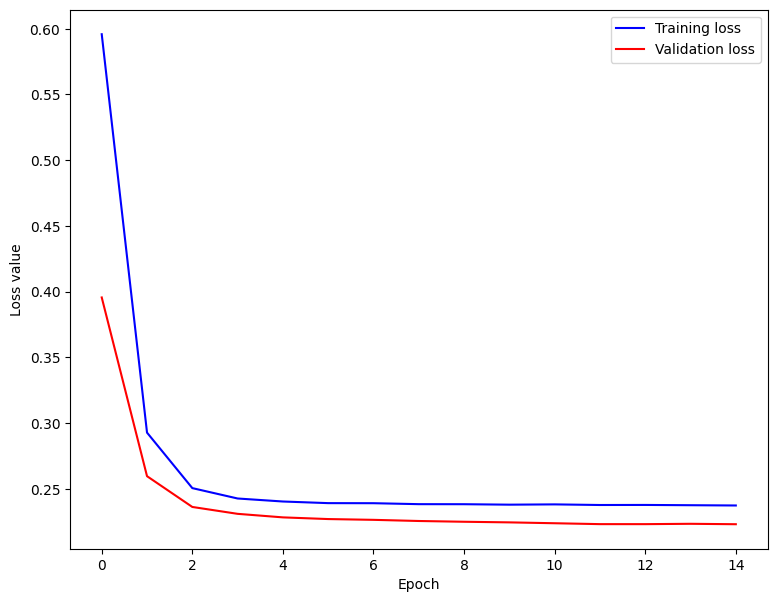

Epoch 1/100
61/61 [==============================] - 2s 11ms/step - loss: 0.2361 - val_loss: 0.2211
Epoch 2/100
61/61 [==============================] - 0s 7ms/step - loss: 0.2338 - val_loss: 0.2205
Epoch 3/100
61/61 [==============================] - 0s 6ms/step - loss: 0.2330 - val_loss: 0.2202
Epoch 4/100
61/61 [==============================] - 0s 6ms/step - loss: 0.2325 - val_loss: 0.2201
Epoch 5/100
61/61 [==============================] - 0s 6ms/step - loss: 0.2322 - val_loss: 0.2199
Epoch 6/100
61/61 [==============================] - 0s 6ms/step - loss: 0.2320 - val_loss: 0.2198
Epoch 7/100
61/61 [==============================] - 0s 5ms/step - loss: 0.2318 - val_loss: 0.2196
Epoch 8/100
61/61 [==============================] - 0s 5ms/step - loss: 0.2316 - val_loss: 0.2194
Epoch 9/100
61/61 [==============================] - 0s 5ms/step - loss: 0.2314 - val_loss: 0.2193
Epoch 10/100
61/61 [==============================] - 0s 6ms/step - loss: 0.2313 - val_loss: 0.2192
Epoch 11

,Förbrukning,dayofweek_sin,dayofweek_cos
Period,,,
2017-06-27 00:00:00+00:00,-1.525745,1.103581,0.881182
2017-06-28 00:00:00+00:00,-1.711217,1.376584,-0.315043
2017-06-29 00:00:00+00:00,-1.845310,0.611647,-1.274341
2017-06-30 00:00:00+00:00,-1.850448,-0.615217,-1.274341
2017-07-01 00:00:00+00:00,-1.906766,-1.380154,-0.315043
...,...,...,...
2023-11-11 00:00:00+00:00,-1.014739,-1.380154,-0.315043
2023-11-12 00:00:00+00:00,-0.997001,-1.107151,0.881182
2023-11-13 00:00:00+00:00,1.319437,-0.001785,1.413552


Shape of training data: (2154, 7, 3)
Shape of the target data: (2154, 3)
Shape of validation data: (168, 7, 3)
Shape of the validation target data: (168, 3)
Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 7, 3)]            0         
                                                                 
 lstm_10 (LSTM)              (None, 20)                1920      
                                                                 
 dense_10 (Dense)            (None, 3)                 63        
                                                                 
Total params: 1,983
Trainable params: 63
Non-trainable params: 1,920
_________________________________________________________________
Epoch 1/20
68/68 [==============================] - 1s 8ms/step - loss: 0.5292 - val_loss: 0.3423
Epoch 2/20
68/68 [==============================] - 0s 5ms/step 

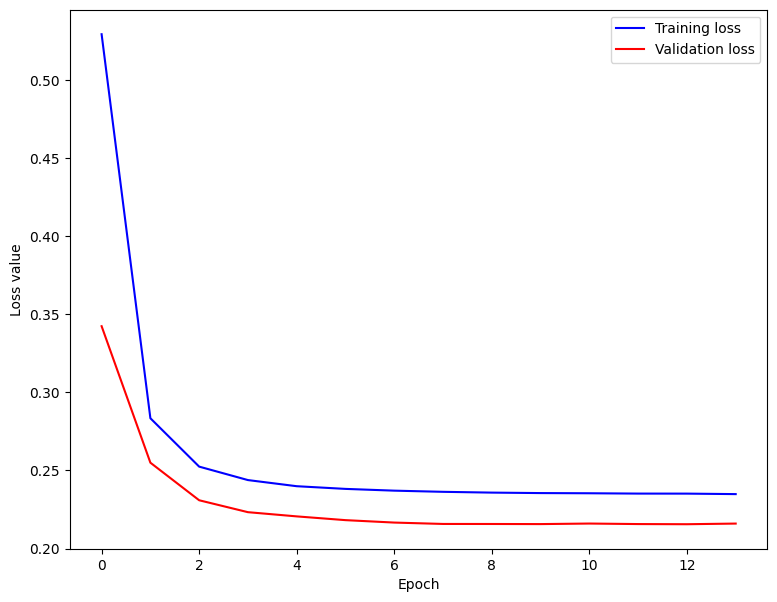

Epoch 1/100
68/68 [==============================] - 2s 8ms/step - loss: 0.2335 - val_loss: 0.2149
Epoch 2/100
68/68 [==============================] - 0s 5ms/step - loss: 0.2316 - val_loss: 0.2143
Epoch 3/100
68/68 [==============================] - 0s 5ms/step - loss: 0.2308 - val_loss: 0.2140
Epoch 4/100
68/68 [==============================] - 0s 5ms/step - loss: 0.2302 - val_loss: 0.2138
Epoch 5/100
68/68 [==============================] - 0s 5ms/step - loss: 0.2298 - val_loss: 0.2137
Epoch 6/100
68/68 [==============================] - 0s 5ms/step - loss: 0.2295 - val_loss: 0.2136
Epoch 7/100
68/68 [==============================] - 0s 6ms/step - loss: 0.2292 - val_loss: 0.2135
Epoch 8/100
68/68 [==============================] - 0s 6ms/step - loss: 0.2290 - val_loss: 0.2134
Epoch 9/100
68/68 [==============================] - 0s 6ms/step - loss: 0.2287 - val_loss: 0.2134
Epoch 10/100
68/68 [==============================] - 0s 6ms/step - loss: 0.2285 - val_loss: 0.2133
Epoch 11/

In [ ]:
tl(
    features, 
    Tallbacka_EL_clean, 
    index, 
    lag,
    n_ahead, 
    n_layer, 
    learning_rate, 
    epochs, 
    batch_size, 
    source_model_path,
    data_sample
)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cc29b291-e846-4c1e-a1b5-7eaef73de259' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>